In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [11]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [17]:
# Inspect the columns in each table
measurementColumns = inspector.get_columns('measurement')
for column in measurementColumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
stationColumns = inspector.get_columns('station')
for column in stationColumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [22]:
# Find the most recent date in the data set.
for row in session.query(Measurement.station, Measurement.date).order_by(Measurement.date.desc()).limit(10).all():
    print(row)
# Ordered by date, the most recent date is 2017-08-23

('USC00519397', '2017-08-23')
('USC00514830', '2017-08-23')
('USC00519523', '2017-08-23')
('USC00516128', '2017-08-23')
('USC00519397', '2017-08-22')
('USC00519523', '2017-08-22')
('USC00516128', '2017-08-22')
('USC00519397', '2017-08-21')
('USC00514830', '2017-08-21')
('USC00519523', '2017-08-21')


In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
precipData = []

# Calculate the date one year from the last date in data set.
# recentYear = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10']
# datesdiff = func.datediff(text(yyyy-mm-dd), '2017-08-23', '2016-08-23')
# Perform a query to retrieve the data and precipitation scores
for row in session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23').order_by(Measurement.date.desc()).all():
    precipData.append(row)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipdf = pd.DataFrame(precipData, columns=['Date','Precipitation'])

# Sort the dataframe by date
precipdf.set_index('Date')


,Precipitation
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
...,...
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


In [35]:

precipdf.sort_index()

,Date,Precipitation
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00
...,...,...
2218,2016-08-24,2.28
2219,2016-08-24,NaN
2220,2016-08-24,1.22
2221,2016-08-24,2.15


In [41]:
# Drop NaN rows
precipdf.dropna(how="any", inplace=True)
precipdf

,Date,Precipitation
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00
...,...,...
2217,2016-08-24,2.15
2218,2016-08-24,2.28
2220,2016-08-24,1.22
2221,2016-08-24,2.15


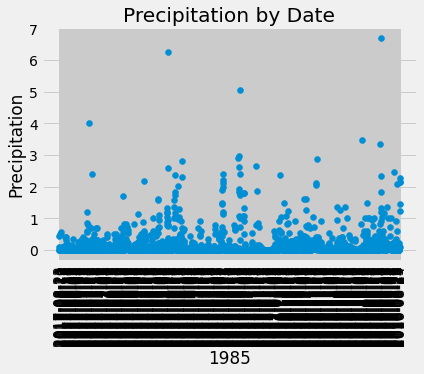

In [38]:

# Use Pandas Plotting with Matplotlib to plot the data
plt.scatter(precipdf['Date'], precipdf['Precipitation'],)
plt.title('Precipitation by Date')
plt.xlabel(recentYear)

plt.ylabel('Precipitation')
plt.xticks(rotation = 90)
plt.show()


In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipdf.describe()

,Precipitation,tobs
count,18103.000000,19550.000000
mean,0.160644,73.097954
std,0.468746,4.523527
min,0.000000,53.000000
25%,0.000000,70.000000
50%,0.010000,73.000000
75%,0.110000,76.000000
max,11.530000,87.000000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()